<font size=4 color='blue'>Copyright: 2020</font>

<font size=4 color='blue'>Author:    Fernand B. Eloundou</font>

---------------------------------------------------------------------------------------------

<font size=4 color='black'>File:     Optimization_of_Soil_Hydraulic_Parameters.ipynb</font>

----------------------------------------------------------------------------------------------

- Optimize soil water retention and hydraulic conductivity curves using HYPROP data at CF I-2.
  Curve fitting with leastsq() function is used for the optimization with three sets of initial guess values.

    * first optimization: arbitrary guess values.

    * second optimization: predicted soil hydraulic parameters using ROSETTA as guess values.

    * third optimization: predicted soil hydraulic parameters using Woesten PTFs (Seidel S., 2020) as guess values.

In [1]:
# import libraries

import pandas as pd
import numpy as np
import xlrd

import matplotlib.pyplot as plt


from scipy.optimize import leastsq
import warnings

In [2]:
# pressure head for analytical solution

h1202 = -np.logspace(-2, 7, 99, endpoint=False)
h1203  = -np.logspace(-2, 7, 99, endpoint=False)

In [3]:
# effective saturation for analytical solution

Se1202 = np.linspace(0, 1.9, 99, endpoint=False)
Se1203 = np.linspace(0, 1.9, 99, endpoint=False)

In [4]:
# load topsoil (1203) HYPROP data
# soil moisture tension (pF) --log of soil matric potential
# log hydraulic conductivity (log K) in cm/d

TH_pF_1203 = pd.read_excel('1203_new.xlsx', sheet_name='Evaluation-Retention-TH(pF)')
TH_pF_1203['h'] = (10 ** TH_pF_1203['pF'])*-1                                  # convert pF to pressure head (h) in cm
TH_pF_1203['theta'] = TH_pF_1203['Water_Content']/100                          # convert water content in percentage to cm3 cm-3

K_pF_1203 = pd.read_excel('1203_new.xlsx', sheet_name='Evaluation-Conductivity-K(pF)')
K_pF_1203['Kh'] = (10 ** (K_pF_1203['log_K']))                          # hydraulic conductivity in function of pressure head

K_TH_1203 = pd.read_excel('1203_new.xlsx', sheet_name='Evaluation-Conductivity-K(TH)')
K_TH_1203['Ktheta'] =  (10 ** (K_TH_1203['log_K']))                     # hydraulic conductivity in function of water content

In [5]:
# topsoil (1203)
# pressure head
h_1203 = TH_pF_1203.h.values  

# Water retention
theta_1203 = TH_pF_1203.theta.values

# Conductivity in function of h
Kh_1203 = K_pF_1203.Kh.values

# Conductivity in function of Theta
Ktheta_1203 = K_TH_1203.Ktheta.values

In [6]:
# load subsoil (1202) HYPROP data
# soil moisture tension (pF) --log of soil matric potential
# log hydraulic conductivity (log K) in cm/d

TH_pF_1202 = pd.read_excel('1202_new.xlsx', sheet_name='Evaluation-Retention-TH(pF)')
K_pF_1202 = pd.read_excel('1202_new.xlsx', sheet_name='Evaluation-Conductivity-K(pF)')
K_TH_1202 = pd.read_excel('1202_new.xlsx', sheet_name='Evaluation-Conductivity-K(TH)')

In [7]:
# Convert pF to pressure head in cm or hectopascal (hPa)
# Convert volumeteric water content in percentage to cm3/cm3 (divide by 100)

TH_pF_1202['h'] = (10 ** TH_pF_1202['pF'])*-1
TH_pF_1202['theta'] = TH_pF_1202['Water_Content']/100

# Conductivity in function of pF
K_pF_1202['Kh'] = (10 ** (K_pF_1202['log_K']))

# Conductivity in function of Theta
K_TH_1202['Ktheta'] =  (10 ** (K_TH_1202['log_K']))

In [8]:
# 1202 (subsoil)
# Water retention
h_1202 = TH_pF_1202.h.values 

# Water retention
theta_1202 = TH_pF_1202.theta.values

# Conductivity in function of h
Kh_1202 = K_pF_1202.Kh.values

# Conductivity in function of Theta
Ktheta_1202 =  K_TH_1202.Ktheta.values

# Optimization of van Genuchtens parameters

- Definition of soil hydraulic parameters

    * theta(h): volumetric water content (cm$^3$ cm$^-$$^3$) at pressure head (cm)
    * theta_r:  volumetric residual water content (cm$^3$ cm$^-$$^3$)
    * theta_s:  volumetric saturated water content (cm$^3$ cm$^-$$^3$)
    * alpha:    inverse of air-entry suction (cm$^-$$^1$) 
    * n:        empirical measure of pore-size distribution
    * m:        empirical constant in function of n
    * _l_:        empirical pore-conductivity often assumed to be 0.5
    * Se:       dimensionless effective/relative saturation
    * k(Se):    hydraulic conductivity (cm d$^-$$^1$) at effective saturation  
    * ksat:     saturated hydraulic conductivity (cm d$^-$$^1$)

In [9]:
# bulk density (BD in g/cm3)
# soil particule density (SPD in g/cm3)

# topsoil bulk density (1203)
BD1203 = 1.70

# subsoil bulk density (1202)
BD1202 = 1.786                
SPD = 2.65                    

In [10]:
# theta_s_1203 (topsoil)
thetas = 1 - (BD1203/SPD)

# theta_s_1202 (subsoil)
theta_s = 1 - (BD1202/SPD)

In [11]:
# topsoil 
def theta(h, thetar, alp, n_):
    thetar, alp, n_ = p
    return (thetas - thetar)/(1 + (-alp*h)**n)**(1-(1/n_)) + thetar

def Residual(p, h_1203, theta_1203):
    thetar, alp, n_ = p
    return ((thetas - thetar)/(1 + (-alp*h_1203)**n_)**(1-(1/n_)) + thetar) - theta_1203

Use the initial guess values for the different optimization and 
the the corresponding epsfcn variable in the leastsq() function to
obtain the same fitted parameters as in the following cells.

In [12]:
# Initial guess values for topsoil
# p = [0.089, 0.01, 1.23]                                   # epsfcn=69     # first opt
# p = [0.0918554, 0.0137085, 1.12510266]                    # epsfcn=700    # first opt robust check
# p = [0.0583, 0.0073, 1.5193]                              # epsfcn=700    # second opt (Rosetta)
p = [0.01, 0.0147, 1.2405]                                # epsfcn=700    # third opt (Seidel, S.,(2020)) 
# p = [0.0136, 0.0147, 1.0729]                              # epsfcn=700    # third opt robust check


# call leastsq to find optimal parameters
fitparams, pcov, infodict, errmsg, success = leastsq(Residual, p, args=(h_1203, theta_1203),\
                                                              ftol=1e-10, xtol=1e-10,full_output=1, epsfcn=700)
print('pfit = ', fitparams)
print('perr = ', np.sqrt(np.diag(pcov)))

# fitted parameters
thetar, alp, n_ = fitparams

pfit =  [0.01357825 0.01469815 1.07292673]
perr =  [ 3.45452364  1.40713555 35.57252561]


In [13]:
# topsoil vG estimates
n1203         = 1.07292673  # 1.07292673     # 1.10594534   # 1.12510266             # third opt # second opt # first opt
alpha_1203    = 0.01469815  # 0.01469815    # 0.00960362  # 0.0137085  
theta_r_1203  = 0.01357825  # 0.01357825    # 0.06079742  # 0.0918554 
theta_s_1203  = thetas
m1203         = 1-(1/n1203)

# Third opt robust check
# n1203         = 1.06784542   
# alpha_1203    = 0.0172135  
# theta_r_1203  = 0.01234652 
# theta_s_1203  = thetas
# m1203         = 1-(1/n1203)

# # First opt robust check
# n1203         = 1.09504103   
# alpha_1203    = 0.01542064
# theta_r_1203  = 0.09210648 
# theta_s_1203  = thetas
# m1203         = 1-(1/n1203)

# empirical pore-conductivity
l            = 0.5

In [14]:
# subsoil
def water_retention(psi, theta_r, alpha, n):
    theta_r, alpha, n = pp
    return (theta_s - theta_r)/(1 + (-alpha*psi)**n)**(1-1/n) + theta_r 

def residual(pp, h_1202, theta_1202):
    theta_r, alpha, n = pp
    return ((theta_s - theta_r)/(1 + (-alpha*h_1202)**n)**(1-(1/n)) + theta_r) - theta_1202

Just like in the case of topsoil, use the initial guess values for the different optimization and 
the the corresponding epsfcn variable in the leastsq() function to
obtain the same fitted parameters as in the following cells.

In [15]:
# Initial guess values for subsoil
# pp = [0.089, 0.01, 1.23]                                             # epsfcn=700        # first opt
# pp = [0.09124942, 0.00881593, 1.1101089]                                                 # first opt robust check
# pp = [0.06, 0.003, 1.4399]                                           # epsfcn=500        # second opt (Rosetta)
pp = [0.01, 0.0128, 1.1218]                                            # epsfcn=700        # third opt (Seidel, S.,(2020))
# pp = [0.01231792, 0.00843022, 1.08161137]                                                # third opt robust check

# call leastsq to find optimal parameters
popts, ppcov, infodict, errmsg, success = leastsq(residual, pp, args=(h_1202, theta_1202),\
                                                              ftol=1e-10, xtol=1e-10,full_output=1, epsfcn=700)
print('pfit = ', popts)
print('perr = ', np.sqrt(np.diag(ppcov)))

# fitted parameters
theta_r, alpha, n = popts

pfit =  [0.01231792 0.00843022 1.08161137]
perr =  [ 4.31386101  0.79276186 41.76209877]


<ipython-input-14-17d05dec4f8c>:8: RuntimeWarning: invalid value encountered in power
  return ((theta_s - theta_r)/(1 + (-alpha*h_1202)**n)**(1-(1/n)) + theta_r) - theta_1202


In [16]:
# subsoil vG estimates
n1202        = 1.08161137   #1.08161137  #1.20031585   # 1.1101089                       # third opt  # second opt # first opt
alpha_1202   = 0.00843022   # 0.00843022  #0.0028405   # 0.00881593        
theta_r_1202 = 0.01231792   # 0.01231792  #0.06367518  # 0.09124942     
theta_s_1202 = theta_s
m1202        = 1-(1/n1202)

# Third opt robust check
# n1202        = 1.08161137      
# alpha_1202   = 0.00843022         
# theta_r_1202 = 0.01231792     
# theta_s_1202 = theta_s
# m1202        = 1-(1/n1202)

# # first opt robust check
# n1202        = 1.11009815   
# alpha_1202   = 0.00881485      
# theta_r_1202 = 0.09124938     
# theta_s_1202 = theta_s
# m1202        = 1-(1/n1202)

In [17]:
# Water content - MvG function

def WaterContent(theta_s, theta_r, alpha, n, h):
    theta = (theta_s - theta_r)/(1+(-alpha*h)**n)**(1-1/n)+theta_r
    return theta

In [18]:
# Analytical solution of MvG function
water_content_1203 = WaterContent(theta_s_1203, theta_r_1203, alpha_1203, n1203, h1203)
water_content_1202 = WaterContent(theta_s_1202, theta_r_1202, alpha_1202, n1202, h1202)

In [19]:
print('Maximum theta 1203: ', theta_1203.max())
print('Minimum theta 1203: ', theta_1203.min())
print('Maximum theta 1202: ', theta_1202.max())
print('Minimum theta 1202: ', theta_1202.min())

Maximum theta 1203:  0.35700000000000004
Minimum theta 1203:  0.29510000000000003
Maximum theta 1202:  0.326
Minimum theta 1202:  0.2729


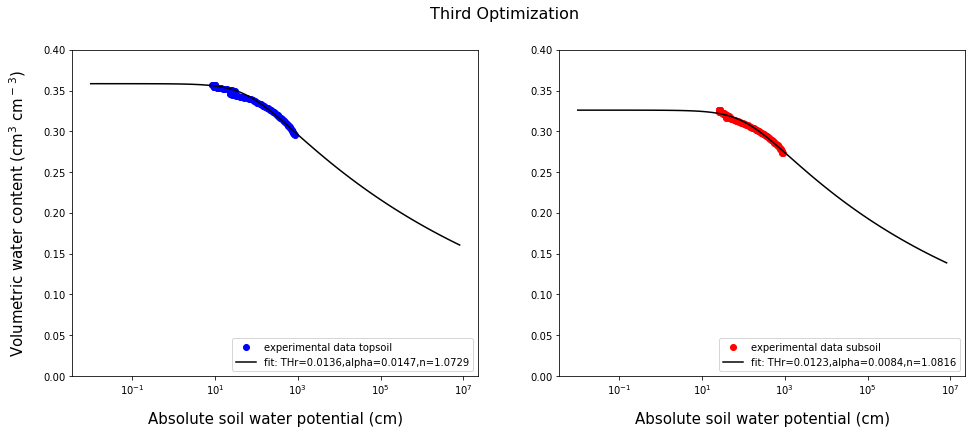

In [20]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle('Third Optimization', fontsize=16)

ax1.semilogx(abs(h_1203), theta_1203, 'bo', label='experimental data topsoil')

ax1.semilogx(abs(h1203), water_content_1203, 'k-', label='fit: THr=%5.4f,alpha=%5.4f,n=%5.4f' % tuple(fitparams))
ax1.set_xlabel('Absolute soil water potential (cm)',fontsize=15, labelpad=15)
ax1.set_ylabel('Volumetric water content (cm$^3$ cm$^-$$^3$)',fontsize=15, labelpad=15)
ax1.set_ylim(0, 0.4)
ax1.set_xscale('log')
ax1.legend(loc='lower right')

ax2.semilogx(abs(h_1202), theta_1202, 'ro', label='experimental data subsoil')

ax2.semilogx(abs(h1202), water_content_1202, 'k-', label='fit: THr=%5.4f,alpha=%5.4f,n=%5.4f' % tuple(popts))
ax2.set_xlabel('Absolute soil water potential (cm)',fontsize=15, labelpad=15)
# ax2.set_ylabel('Water content(-)',fontsize=20)
ax2.set_ylim(0, 0.4)
ax2.set_xscale('log')
ax2.legend(loc='lower right')

# plt.savefig('Van Genchtens parameters estimation.png')
# plt.savefig('Van Genchtens parameters estimation_Second_Opt.png')
plt.savefig('Van Genchtens parameters estimation_Third_Opt.png')
# plt.savefig('Van Genchtens parameters estimation-robust-First-Opt.png')
# plt.savefig('Van Genchtens parameters estimation-robust-Third-Opt.png')
plt.show()

In [21]:
# Statistic measures for topsoil van Genuchten parameters
# Root mean squared error
ypred = WaterContent(theta_s_1203, theta_r_1203, alpha_1203, n1203, h_1203)
ytrue = theta_1203
sse = sum((ypred - ytrue)**2)
rmse = np.sqrt(sse/len(ytrue)).round(3)


# Coefficient of determination
def squared_error(ys_orig,ys_line):
    return sum((ys_line - ys_orig) * (ys_line - ys_orig))

def coefficient_of_determination(ys_orig,ys_line):
    y_mean_line = [np.mean(ys_orig) for y in ys_orig]
    squared_error_regr = squared_error(ys_orig, ys_line)
    squared_error_y_mean = squared_error(ys_orig, y_mean_line)
    return 1 - (squared_error_regr/squared_error_y_mean)

r_squared = coefficient_of_determination(ytrue, ypred).round(3)

print('Accuracy measurement for van Genuchtens parameters 1203')
print('RMSE :', rmse)
print('R_squared :', r_squared)

Accuracy measurement for van Genuchtens parameters 1203
RMSE : 0.003
R_squared : 0.982


In [22]:
# Statistic measures for subsoil van Genuchten parameters
# Root mean squared error
y_pred = WaterContent(theta_s_1202, theta_r_1202, alpha_1202, n1202, h_1202)
y_true = theta_1202
SSE = sum((y_pred - y_true)**2)
RMSE = np.sqrt(SSE/len(y_true)).round(3)


# Coefficient of determination
R_squared = coefficient_of_determination(y_true, y_pred).round(3)

print('Accuracy measurement for van Genuchtens parameters 1202')
print('RMSE :', RMSE)
print('R_squared :', R_squared)

Accuracy measurement for van Genuchtens parameters 1202
RMSE : 0.002
R_squared : 0.982


# Estimation of hydraulic conductivity

In [23]:
# Effective saturation (Se)

def saturation(theta, theta_r, theta_s):
    return (theta - theta_r)/(theta_s - theta_r)

In [24]:
# Analytical solution 
Se_h_1203 = saturation(theta_1203, theta_r_1203, theta_s_1203)          # effective saturation in topsoil
Se_h_1202 = saturation(theta_1202, theta_r_1202, theta_s_1202)          # effective saturation in subsoil

In [25]:
print('Maximum Se 1203: ', Se_h_1203.max())
print('Minimum Se 1203: ', Se_h_1203.min())
print('Maximum Se 1202: ', Se_h_1202.max())
print('Minimum Se 1202: ', Se_h_1202.min())

Maximum Se 1203:  0.995678420374027
Minimum Se 1203:  0.8162125181090939
Maximum Se 1202:  0.9998797148055361
Minimum Se 1202:  0.8306204034155644


In [26]:
# Unssaturated hydraulic conductivity in function of Se

def hydrualic_conductivity(Se, Ks, m):
    return (Ks*Se**l)*(1 - (1-Se**(1/m))**m)**2

In [27]:
Se1203_ = Se_h_1203[:85]


def Res(p_, Se1203_, Kh_1203):
    ksat = p_
    return ((ksat*Se1203_**l)*(1 - (1-Se1203_**(1/m1203))**m1203)**2) - Kh_1203

In [28]:
# Initial guesses
# p_ = [10]                                          # first opt
# p_ = [6.0696]                                  # first opt robust check
# p_ = [5.51]                                        # second opt (Rosetta)
p_ = [9.8496]                                      # third opt (Seidel (2020))
# p_ = [10.5764]                                  # third opt robust check

# call leastsq to find optimal parameters
fitparam, pcov, infodict, errmsg, success = leastsq(Res, p_, args=(Se1203_, Kh_1203),\
                                                              ftol=1e-10, xtol=1e-10,full_output=1, epsfcn=0.1)
print('pfit = ', fitparam)
print('perr = ', np.sqrt(np.diag(pcov)))

# fitted parameters
ksat = fitparam

pfit =  [10.57638516]
perr =  [9.18187047]


In [29]:
Se1202_ = Se_h_1202


def res(pp_, Se1202_, Kh_1202):
    Ks = pp_
    return ((Ks*Se1202_**l)*(1 - (1-Se1202_**(1/m1202))**m1202)**2) - Kh_1202

In [30]:
# Initial guesses
# pp_ = [10]                                            # first opt
# pp_ = [0.53694105]                                    # first opt robust check
# pp_ = [2.68]                                          # second opt (Rosetta)
pp_ = [9.1584]                                        # third opt (Seidel, S.(2020))
# pp_ = [0.81449685]                                    # third opt robust check

# call leastsq to find optimal parameters
popt, ppcov, infodict, errmsg, success = leastsq(res, pp_, args=(Se1202_, Kh_1202),\
                                                              ftol=1e-10, xtol=1e-10,full_output=1, epsfcn=0.1)
print('pfit = ', popt)
print('perr = ', np.sqrt(np.diag(ppcov)))

# fitted parameters
Ks = popt

pfit =  [0.81449685]
perr =  [2.68405156]


In [31]:
# Hydraulic Conductivity in function of relative saturaturation (K(Se))

KSe_1203 = hydrualic_conductivity(Se1203_, ksat, m1203)
KSe_1202 = hydrualic_conductivity(Se1202_, Ks, m1202)

In [32]:
# Analytic solution for K(Se)
K1203 = hydrualic_conductivity(Se1203[:85], ksat, m1203)
K1202 = hydrualic_conductivity(Se1202, Ks, m1202)

<ipython-input-26-7d3dcddbd0f1>:4: RuntimeWarning: invalid value encountered in power
  return (Ks*Se**l)*(1 - (1-Se**(1/m))**m)**2


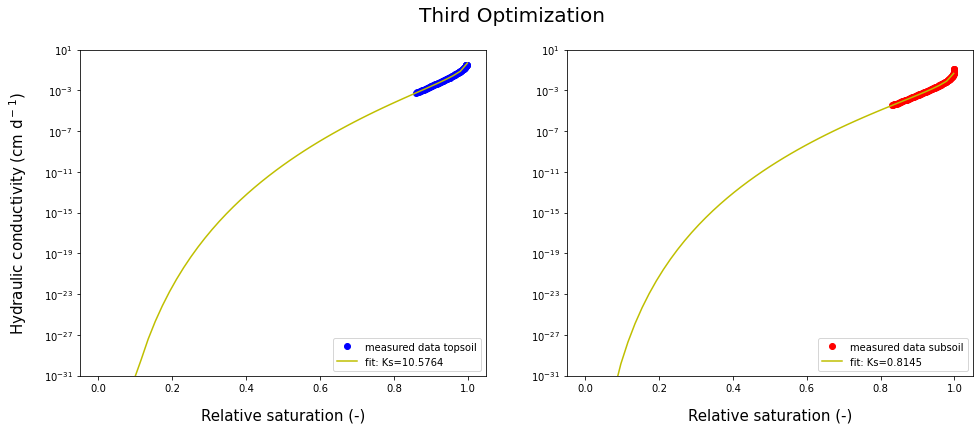

In [33]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle('Third Optimization', fontsize=20)

ax1.semilogy(Se1203_, KSe_1203, 'bo', label='measured data topsoil')

ax1.semilogy(Se1203[:85], K1203, 'y-', label='fit: Ks=%5.4f' % tuple(fitparam))
ax1.set_xlabel('Relative saturation (-)',fontsize=15, labelpad=15)
ax1.set_ylabel('Hydraulic conductivity (cm d$^-$$^1$)',fontsize=15, labelpad=15)
# # ax1.set_yscale('log')
ax1.set_ylim(10**-31, 10**1)
ax1.legend(loc='lower right')

ax2.semilogy(Se1202_, KSe_1202, 'ro', label='measured data subsoil')

ax2.semilogy(Se1202, K1202, 'y-', label='fit: Ks=%5.4f' % tuple(popt))
ax2.set_xlabel('Relative saturation (-)',fontsize=15, labelpad=15)
# ax2.set_ylabel('Hydraulic Conductivity (cm/day)',fontsize=14)
# # ax2.set_yscale('log')
ax2.set_ylim(10**-31, 10**1)
ax2.legend(loc='lower right')

# plt.savefig('Hydraulic conductivity estimate.png')
# plt.savefig('Hydraulic conductivity estimate_Second_Opt.png')
plt.savefig('Hydraulic conductivity estimate_Third_Opt.png')
# plt.savefig('Hydraulic conductivity estimate-robust-First-Opt.png')
# plt.savefig('Hydraulic conductivity estimate-robust-Third-Opt.png')
plt.show()

In [34]:
# Statistic measures for topsoil van Genuchten parameters
# Root mean squared error
ypred = hydrualic_conductivity(Se1203_, fitparam, m1203)
ytrue = KSe_1203
sse = sum((ypred - ytrue)**2)
rmse = np.sqrt(sse/len(ytrue)).round(3)


# Coefficient of determination
def squared_error(ys_orig,ys_line):
    return sum((ys_line - ys_orig) * (ys_line - ys_orig))

def coefficient_of_determination(ys_orig,ys_line):
    y_mean_line = [np.mean(ys_orig) for y in ys_orig]
    squared_error_regr = squared_error(ys_orig, ys_line)
    squared_error_y_mean = squared_error(ys_orig, y_mean_line)
    return 1 - (squared_error_regr/squared_error_y_mean)

r_squared = coefficient_of_determination(ytrue, ypred).round(3)

print('Accuracy measurement for hydraulic conductivity 1203')
print('RMSE :', rmse)
print('R_squared :', r_squared)

Accuracy measurement for hydraulic conductivity 1203
RMSE : 0.0
R_squared : 1.0


In [35]:
# Statistic measures for subsoil van Genuchten parameters
# Root mean squared error
ypred = hydrualic_conductivity(Se1202_, popt, m1202)
# ypred =((Ks*Se1202_**l)*(1 - (1-Se1202_**(1/m1202))**m1202)**2)
ytrue = KSe_1202
sse = sum((ypred - ytrue)**2)
rmse = np.sqrt(sse/len(ytrue)).round(3)


# Coefficient of determination
def squared_error(ys_orig,ys_line):
    return sum((ys_line - ys_orig) * (ys_line - ys_orig))

def coefficient_of_determination(ys_orig,ys_line):
    y_mean_line = [np.mean(ys_orig) for y in ys_orig]
    squared_error_regr = squared_error(ys_orig, ys_line)
    squared_error_y_mean = squared_error(ys_orig, y_mean_line)
    return 1 - (squared_error_regr/squared_error_y_mean)

r_squared = coefficient_of_determination(ytrue, ypred).round(3)

print('Accuracy measurement for hydraulic conductivity 1202')
print('RMSE :', rmse)
print('R_squared :', r_squared)

Accuracy measurement for hydraulic conductivity 1202
RMSE : 0.0
R_squared : 1.0
